# Neural Network Implementation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


In [41]:
# Define paths
processed_data_dir = Path('../data/processed')

# List processed files
processed_files = list(processed_data_dir.glob('*_processed.csv'))
print(f"Found {len(processed_files)} processed data files:")
for file in processed_files:
    print(f"  - {file.name}")

# Load data into a dictionary
data_dict = {}
for file_path in processed_files:
    data_type = file_path.stem.replace('_processed', '')
    print(f"\nLoading {data_type}...")
    
    try:
        df = pd.read_csv(file_path)
        # Convert datetime column
        df['datetime'] = pd.to_datetime(df['datetime'])
        data_dict[data_type] = df
        print(f"  ✓ Loaded {len(df)} records")
        print(f"  ✓ Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"  ✓ Columns: {list(df.columns)}")
    except Exception as e:
        print(f"  ✗ Error loading {data_type}: {e}")

print(f"\nSuccessfully loaded {len(data_dict)} datasets")


Found 5 processed data files:
  - cross_current_processed.csv
  - water_height_processed.csv
  - wave_height_processed.csv
  - wind_direction_processed.csv
  - wind_speed_processed.csv

Loading cross_current...
  ✓ Loaded 26723 records
  ✓ Date range: 2025-01-01 00:00:00+00:00 to 2025-07-09 12:00:00+00:00
  ✓ Columns: ['datetime', 'datetime_unix', 'value', 'X', 'Y']

Loading water_height...
  ✓ Loaded 26531 records
  ✓ Date range: 2025-01-01 00:00:00+00:00 to 2025-07-09 12:00:00+00:00
  ✓ Columns: ['datetime', 'datetime_unix', 'value', 'X', 'Y']

Loading wave_height...
  ✓ Loaded 26592 records
  ✓ Date range: 2025-01-01 00:00:00+00:00 to 2025-07-09 12:00:00+00:00
  ✓ Columns: ['datetime', 'datetime_unix', 'value', 'X', 'Y']

Loading wind_direction...
  ✓ Loaded 27166 records
  ✓ Date range: 2025-01-01 00:00:00+00:00 to 2025-07-09 12:00:00+00:00
  ✓ Columns: ['datetime', 'datetime_unix', 'value', 'X', 'Y']

Loading wind_speed...
  ✓ Loaded 27166 records
  ✓ Date range: 2025-01-01 00:00:

In [42]:
def prepare_current_direction_features(data_dict):
    """
    Prepare features and targets for current direction prediction.
    
    Args:
        data_dict: Dictionary of datasets
        sequence_length: Number of time steps to use as input
        
    Returns:
        Tuple of (features, targets, feature_columns, target_column)
    """
    print("Preparing features for current direction prediction...")
    
    # Merge all datasets on datetime
    merged_data = None
    for data_type, df in data_dict.items():
        df_copy = df.copy()
        # Rename value to avoid conflicts
        df_copy = df_copy.rename(columns={'value': f'{data_type}'})
        
        if merged_data is None:
            merged_data = df_copy[['datetime', 'datetime_unix', f'{data_type}']]
        else:
            merged_data = merged_data.merge(
                df_copy[['datetime', f'{data_type}']], 
                on='datetime', how='inner'
            )
    
    # Sort by datetime
    merged_data = merged_data.sort_values('datetime').reset_index(drop=True)
    
    # Select feature columns (all variables except current_direction)
    feature_columns = [col for col in merged_data.columns]
    target_column = 'cross_current'
    
    # Remove target from features
    if target_column in feature_columns:
        feature_columns.remove(target_column)
        feature_columns.remove('datetime')
    
    # Prepare features and targets
    features = merged_data[feature_columns].values
    targets = merged_data[target_column].values
    
    print(f"  ✓ Features shape: {features.shape}")
    print(f"  ✓ Targets shape: {targets.shape}")
    print(f"  ✓ Feature columns: {feature_columns}")
    print(f"  ✓ Target column: {target_column}")
    
    return features, targets, feature_columns, target_column

# Prepare data for current direction prediction
features, targets, feature_columns, target_column = prepare_current_direction_features(data_dict)


Preparing features for current direction prediction...
  ✓ Features shape: (26029, 5)
  ✓ Targets shape: (26029,)
  ✓ Feature columns: ['datetime_unix', 'water_height', 'wave_height', 'wind_direction', 'wind_speed']
  ✓ Target column: cross_current


In [43]:
class CrossCurrentDataset(Dataset):
    """Custom Dataset for cross-current time series data."""
    
    def __init__(self, data, targets, sequence_length=24):
        """
        Initialize the dataset.
        
        Args:
            data: Input features (n_samples, n_features)
            targets: Target values (n_samples, n_targets)
            sequence_length: Number of time steps to use as input
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        # Get sequence of input data
        x = self.data[idx:idx + self.sequence_length]
        # Get target (next value after sequence)
        y = self.targets[idx + self.sequence_length]
        return x, y


In [44]:
class ErfActivation(nn.Module):
    def forward(self, x):
        return torch.special.erf(x)

class FlexibleLSTM(nn.Module):
    """
    Flexible LSTM architecture with variable layers, depth, and dropout.
    """
    
    def __init__(self, input_size, depth, width, output_size=1, 
                 dropout=0.2, fc_dropout=0.3, activation='relu'):
        """
        Initialize the flexible LSTM.
        
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden sizes for each LSTM layer
            output_size: Number of output features (default: 1)
            dropout: Dropout rate between LSTM layers
            fc_dropout: Dropout rate in fully connected layers
            activation: Activation function ('relu', 'tanh', 'leaky_relu')
        """
        super(FlexibleLSTM, self).__init__()
        
        self.input_size = input_size
        self.depth = depth
        self.width = width
        self.output_size = output_size
        self.dropout = dropout
        self.fc_dropout = fc_dropout

        # Activation function mapping
        activation_functions = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'sigmoid': nn.Sigmoid(),
            'erf': ErfActivation()
        }
        
        self.activation = activation_functions.get(activation, nn.ReLU())
        
        # LSTM layers
        self.lstm_layers = nn.ModuleList()
        
        # First LSTM layer
        self.lstm_layers.append(nn.LSTM(
            input_size=input_size,
            hidden_size=width,
            num_layers=1,
            batch_first=True,
            dropout=0
        ))
        
        # Additional LSTM layers
        for i in range(1, depth):
            self.lstm_layers.append(nn.LSTM(
                input_size=width,
                hidden_size=width,
                num_layers=1,
                batch_first=True,
                dropout=0
            ))
        
        # Dropout layers between LSTM layers
        self.lstm_dropout = nn.Dropout(dropout)
        
        # Fully connected layers with configurable depth
        fc_sizes = [width]
        
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_sizes) - 1):
            self.fc_layers.append(nn.Linear(fc_sizes[i], fc_sizes[i + 1]))
            if i < len(fc_sizes) - 2:
                self.fc_layers.append(nn.Dropout(fc_dropout))
        
        # Output layer
        self.output_layer = nn.Linear(fc_sizes[-1], output_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for better training."""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Pass through LSTM layers
        lstm_output = x
        for i, lstm_layer in enumerate(self.lstm_layers):
            # LSTM forward pass
            lstm_output, (hidden, cell) = lstm_layer(lstm_output)
            
            # Apply dropout (except after the last LSTM layer)
            if i < len(self.lstm_layers) - 1:
                lstm_output = self.lstm_dropout(lstm_output)
        
        # Take the last output from the final LSTM layer
        last_output = lstm_output[:, -1, :]
        
        # Pass through fully connected layers
        fc_output = last_output
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                fc_output = layer(fc_output)
                fc_output = self.activation(fc_output)
            elif isinstance(layer, nn.Dropout):
                fc_output = layer(fc_output)
        
        # Output layer (no activation for regression)
        output = self.output_layer(fc_output)
        
        return output

In [45]:
def create_datasets(features, targets, train_split=0.7, val_split=0.15, sequence_length=24):
    """
    Create train, validation, and test datasets.
    
    Args:
        features: Input features
        targets: Target values
        train_split: Fraction of data for training
        val_split: Fraction of data for validation
        sequence_length: Number of time steps for sequences
        
    Returns:
        Tuple of (train_dataset, val_dataset, test_dataset)
    """
    print("Creating datasets...")
    
    # Calculate split indices
    n_samples = len(features) - sequence_length
    train_end = int(n_samples * train_split)
    val_end = int(n_samples * (train_split + val_split))
    
    # Create datasets
    train_dataset = CrossCurrentDataset(
        features[:train_end + sequence_length], 
        targets[:train_end + sequence_length], 
        sequence_length
    )
    
    val_dataset = CrossCurrentDataset(
        features[train_end:val_end + sequence_length], 
        targets[train_end:val_end + sequence_length], 
        sequence_length
    )
    
    test_dataset = CrossCurrentDataset(
        features[val_end:], 
        targets[val_end:], 
        sequence_length
    )
    
    print(f"  ✓ Train samples: {len(train_dataset)}")
    print(f"  ✓ Validation samples: {len(val_dataset)}")
    print(f"  ✓ Test samples: {len(test_dataset)}")
    
    return train_dataset, val_dataset, test_dataset

# Create datasets
sequence_length = 24
train_dataset, val_dataset, test_dataset = create_datasets(features, targets, sequence_length=sequence_length)


Creating datasets...
  ✓ Train samples: 18203
  ✓ Validation samples: 3901
  ✓ Test samples: 3901


In [46]:
def train_model(train_dataset, val_dataset, model_config=None):
    """
    Train the neural network model.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        model_config: Model configuration parameters
        
    Returns:
        Tuple of (model, training_history)
    """
    
    print("Training neural network model for current direction prediction...")
    print(f"Model config: {model_config}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=model_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=model_config['batch_size'], shuffle=False)
    
    # Initialize model
    input_size = train_dataset.data.shape[1]
    print(f"Input size: {input_size}")
    model = FlexibleLSTM(
        input_size=input_size,
        depth=model_config['depth'],
        width=model_config['width'],
        dropout=model_config['dropout'],
        fc_dropout=model_config['fc_dropout'],
        activation=model_config['activation']
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=model_config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.10)
    
    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(model_config['epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '../models/best_current_direction_model.pth')
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{model_config["epochs"]}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if patience_counter >= model_config['patience']:
            print(f'Early stopping at epoch {epoch+1}')
            break

        # Stop if the learning rate is too low
        if optimizer.param_groups[0]['lr'] < 1e-6:
            print(f'Learning rate too low at epoch {epoch+1}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('../models/best_current_direction_model.pth'))
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}


In [47]:
# Model configuration for cross-current direction prediction
model_config = {
    'depth': 2,
    'width': 32,
    'dropout': 0.4,
    'fc_dropout': 0.7,
    'activation': 'erf',
    'batch_size': 64,
    'epochs': 100,
    'patience': np.inf,
    'learning_rate': 0.1
}

# Train the model
model, history = train_model(train_dataset, val_dataset, model_config)


Training neural network model for current direction prediction...
Model config: {'depth': 2, 'width': 32, 'dropout': 0.4, 'fc_dropout': 0.7, 'activation': 'erf', 'batch_size': 64, 'epochs': 100, 'patience': inf, 'learning_rate': 0.1}
Input size: 5
Epoch [10/100], Train Loss: 0.166312, Val Loss: 0.155418, LR: 0.010000
Epoch [20/100], Train Loss: 0.122632, Val Loss: 0.134133, LR: 0.010000
Epoch [30/100], Train Loss: 0.100024, Val Loss: 0.115301, LR: 0.010000
Epoch [40/100], Train Loss: 0.082323, Val Loss: 0.165518, LR: 0.001000
Epoch [50/100], Train Loss: 0.081659, Val Loss: 0.170124, LR: 0.000010
Learning rate too low at epoch 59


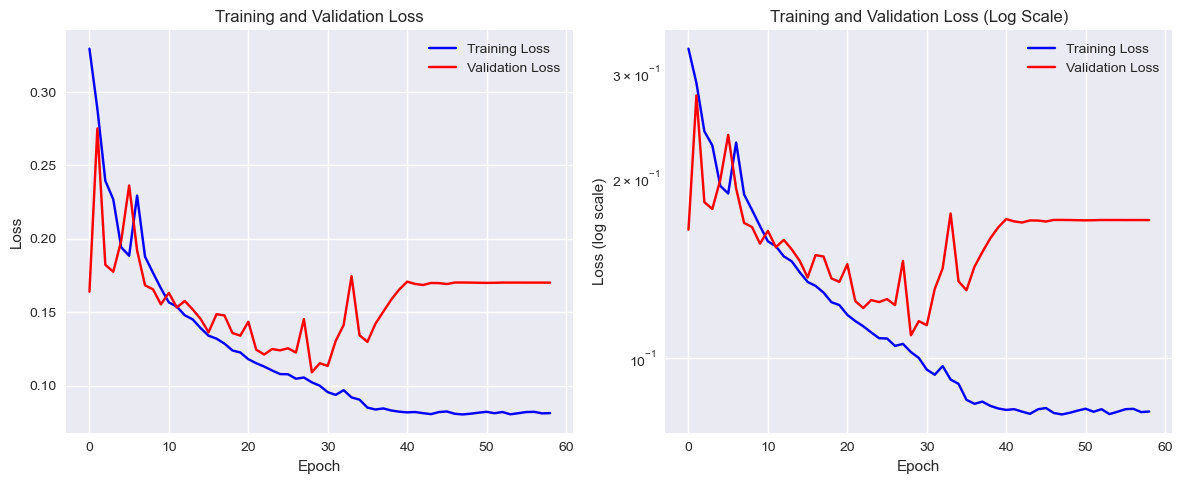

In [48]:
def plot_training_history(history):
    """Plot training and validation loss."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss', color='blue')
    plt.plot(history['val_losses'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(history['train_losses'], label='Training Loss', color='blue')
    plt.semilogy(history['val_losses'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


In [49]:
def evaluate_model(model, test_dataset, scaler=None):
    """
    Evaluate the model on test data.
    
    Args:
        model: Trained model
        test_dataset: Test dataset
        scaler: Optional scaler for denormalization
        
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(batch_y.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print("Current Direction Model Performance:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.6f}")
    
    return metrics, predictions, actuals


In [50]:
# Evaluate on test set
metrics, predictions, actuals = evaluate_model(model, test_dataset)


Current Direction Model Performance:
  MSE: 0.124879
  RMSE: 0.353382
  MAE: 0.266227
  R2: 0.868076


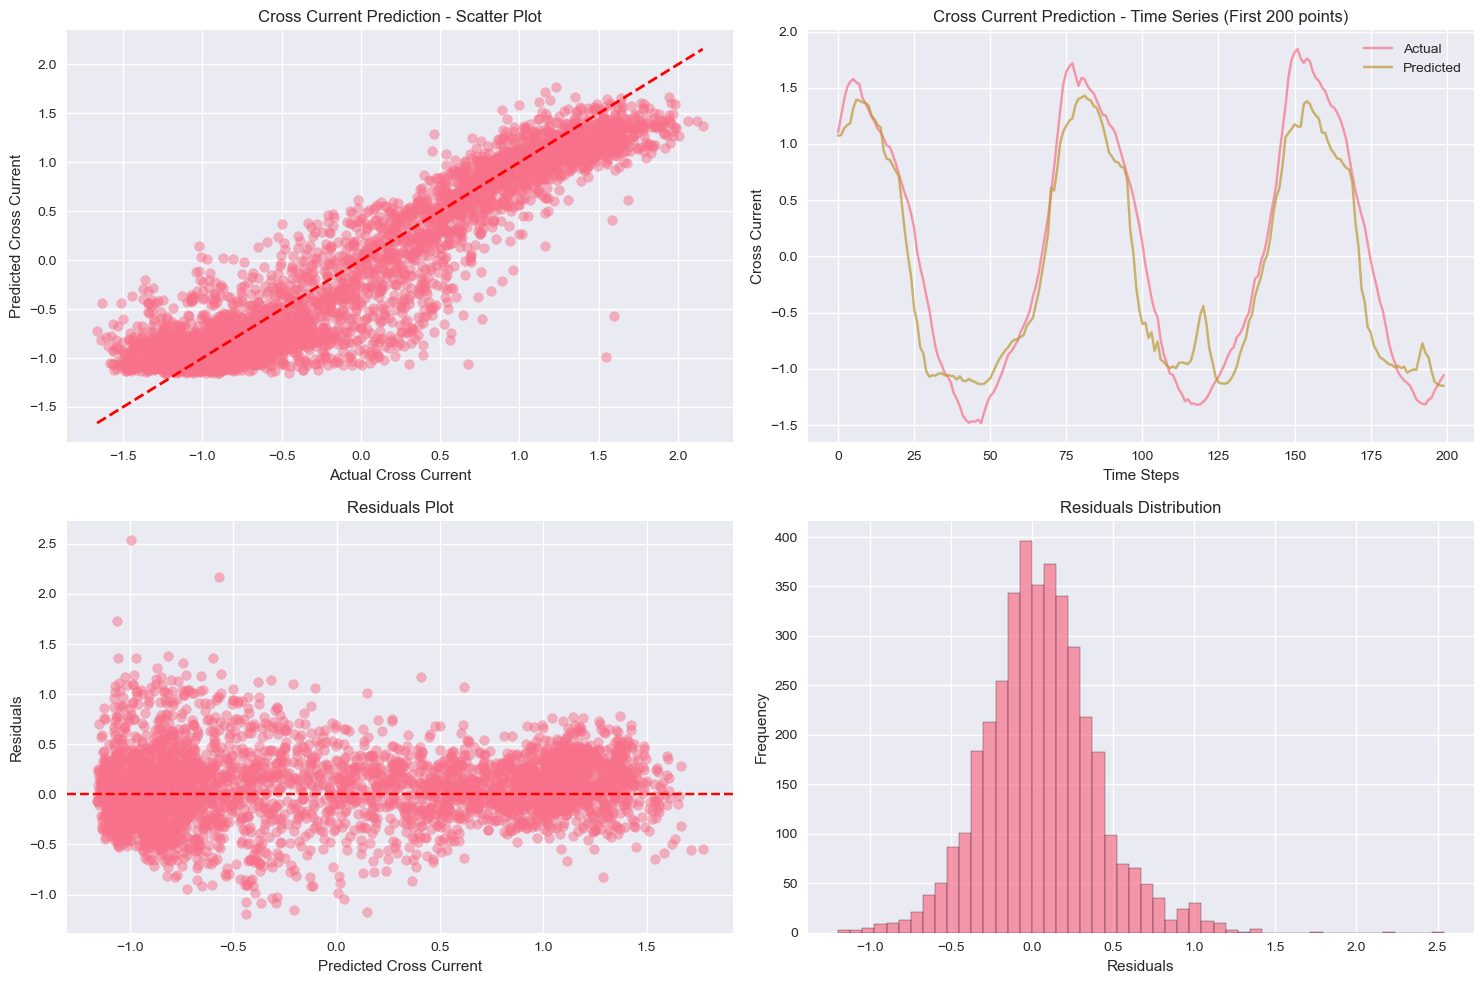

In [51]:
def plot_predictions(actuals, predictions, title="Current Direction Predictions vs Actual"):
    """Plot predictions against actual values."""
    plt.figure(figsize=(15, 10))
    
    # Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Cross Current')
    plt.ylabel('Predicted Cross Current')
    plt.title(f'{title} - Scatter Plot')
    plt.grid(True)
    
    # Time series plot (first 200 points)
    plt.subplot(2, 2, 2)
    n_points = min(200, len(actuals))
    plt.plot(actuals[:n_points], label='Actual', alpha=0.7)
    plt.plot(predictions[:n_points], label='Predicted', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Cross Current')
    plt.title(f'{title} - Time Series (First {n_points} points)')
    plt.legend()
    plt.grid(True)
    
    # Residuals plot
    plt.subplot(2, 2, 3)
    residuals = actuals - predictions
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Cross Current')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.grid(True)
    
    # Residuals histogram
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(actuals, predictions, "Cross Current Prediction")


Current Direction Model Performance:
  MSE: 0.124879
  RMSE: 0.353382
  MAE: 0.266227
  R2: 0.868076
Testing feature: datetime_unix
Current Direction Model Performance:
  MSE: 0.114932
  RMSE: 0.339016
  MAE: 0.253753
  R2: 0.878584
Testing feature: water_height
Current Direction Model Performance:
  MSE: 1.552675
  RMSE: 1.246064
  MAE: 0.999615
  R2: -0.640270
Testing feature: wave_height
Current Direction Model Performance:
  MSE: 0.138607
  RMSE: 0.372299
  MAE: 0.275680
  R2: 0.853574
Testing feature: wind_direction
Current Direction Model Performance:
  MSE: 0.129939
  RMSE: 0.360471
  MAE: 0.268317
  R2: 0.862730
Testing feature: wind_speed
Current Direction Model Performance:
  MSE: 0.129878
  RMSE: 0.360386
  MAE: 0.272975
  R2: 0.862795


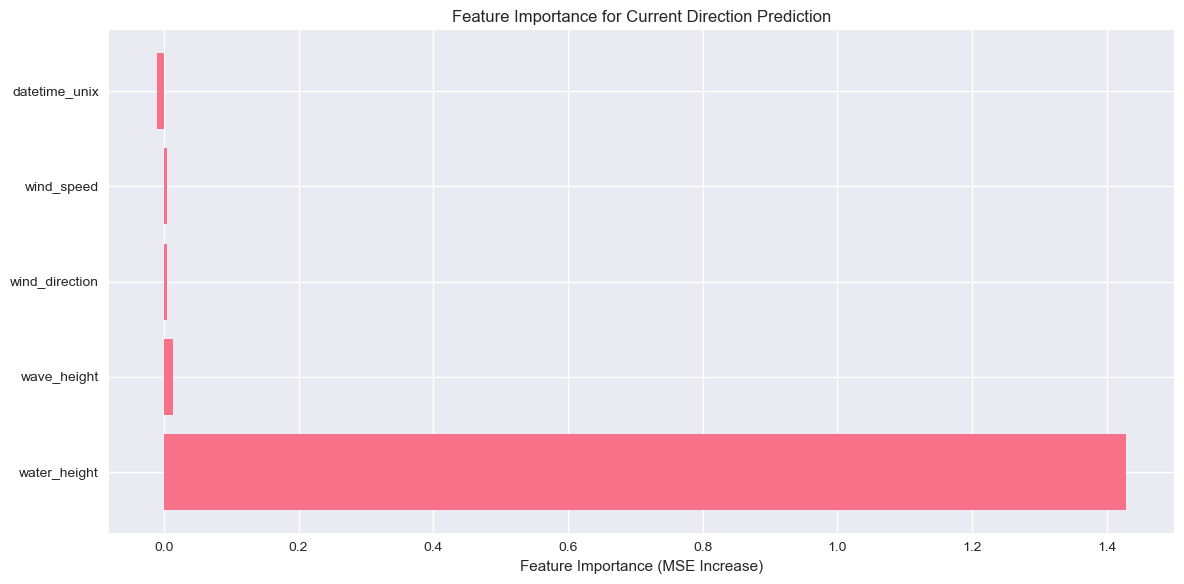

In [52]:
def analyze_feature_importance(model, feature_columns, test_dataset):
    """Analyze feature importance using permutation importance."""
    
    # Get baseline performance
    baseline_metrics, _, _ = evaluate_model(model, test_dataset)
    baseline_mse = baseline_metrics['MSE']
    
    importance_scores = {}
    
    # Test each feature
    for i, feature_name in enumerate(feature_columns):
        print(f"Testing feature: {feature_name}")
        
        # Create modified test dataset with shuffled feature
        modified_data = test_dataset.data.clone()
        modified_data[:, i] = torch.randn_like(modified_data[:, i])
        
        modified_dataset = CrossCurrentDataset(
            modified_data.numpy(), 
            test_dataset.targets.numpy(), 
            test_dataset.sequence_length
        )
        
        # Evaluate with modified feature
        modified_metrics, _, _ = evaluate_model(model, modified_dataset)
        modified_mse = modified_metrics['MSE']
        
        # Importance is the increase in MSE
        importance = modified_mse - baseline_mse
        importance_scores[feature_name] = importance
    
    # Sort features by importance
    sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_names = [f[0] for f in sorted_features]
    importance_values = [f[1] for f in sorted_features]
    
    plt.barh(range(len(feature_names)), importance_values)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Feature Importance (MSE Increase)')
    plt.title('Feature Importance for Current Direction Prediction')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    return importance_scores

# Analyze feature importance
importance_scores = analyze_feature_importance(model, feature_columns, test_dataset)


In [53]:
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'feature_columns': feature_columns,
    'target_column': target_column,
    'sequence_length': sequence_length,
    'metrics': metrics
}, '../models/current_direction_lstm_model.pth')

print("Current direction model saved successfully!")

# Save results to CSV
# results_df = pd.DataFrame({
#     'actual_current_direction': actuals,
#     'predicted_current_direction': predictions,
#     'residuals': actuals - predictions
# })

# results_df.to_csv('current_direction_predictions.csv', index=False)
# print("Current direction results saved to current_direction_predictions.csv")


Current direction model saved successfully!


In [54]:
print("="*60)
print("CURRENT DIRECTION LSTM NEURAL NETWORK SUMMARY")
print("="*60)
print(f"Target Variable: {target_column}")
print(f"Number of Features: {len(feature_columns)}")
print(f"Feature Variables: {feature_columns}")
print(f"Sequence Length: {sequence_length} (4 hours with 10-minute intervals)")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.6f}")
print("\nTop 5 Most Important Features:")
sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_features[:5]):
    print(f"  {i+1}. {feature}: {importance:.6f}")
print("\nModel Architecture:")
print(f"  LSTM Layers: {model_config['width']}")
print(f"  Hidden Size: {model_config['depth']}")
print(f"  Dropout: {model_config['dropout']}")
print(f"  Learning Rate: {model_config['learning_rate']}")
print("="*60)

CURRENT DIRECTION LSTM NEURAL NETWORK SUMMARY
Target Variable: cross_current
Number of Features: 5
Feature Variables: ['datetime_unix', 'water_height', 'wave_height', 'wind_direction', 'wind_speed']
Sequence Length: 24 (4 hours with 10-minute intervals)
Training Samples: 18203
Validation Samples: 3901
Test Samples: 3901

Model Performance:
  MSE: 0.124879
  RMSE: 0.353382
  MAE: 0.266227
  R2: 0.868076

Top 5 Most Important Features:
  1. water_height: 1.427796
  2. wave_height: 0.013728
  3. wind_direction: 0.005061
  4. wind_speed: 0.004999
  5. datetime_unix: -0.009947

Model Architecture:
  LSTM Layers: 32
  Hidden Size: 2
  Dropout: 0.4
  Learning Rate: 0.1
